In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import numpy as np

## this is a program that solved the wave equation
## as a coupled set of ODEs 
# <span style = "color: red" >  Need to go through the this code once more </span>

# Define a couple set of ODEs to integrate 

In [2]:
def dfdx(x,f):
    '''From what I can tell this only arranges the values'''
    
    
    #d2y/dx2 = -y
    #define : 
    
    # y = f[0]
    # dy/dx = z 
    # z = f[1]
    
    y = f[0]
    z = f[1]
    
    #return derivatives 
    dydx = np.zeros_like(f) #will give the same shape as the passed array 
    
    #x = [a,b,c] then np.zeros_like(x)= [0,0,]
    
    dydx[0] = z
    dydx[1] = -1*y
    
    return dydx 

# Define the core of the Cash karp method 

In [5]:
def cash_karp_core_mv(x_i,y_i,nv,h,f): 
    
    #cash karp is defined in terms 
    #of weighting variables 
    
    ni  = 7
    nj  = 6 
    ci  = np.zeros(ni)
    aij = np.zeros( (ni,nj) )
    bi  = np.zeros(ni)
    bis = np.zeros(ni)
    
    #input values for ci, aij,bi,bis
    
    ci[2] = 1./5.
    ci[3] = 3./10.
    ci[4] = 3./5.
    ci[5] = 1.
    ci[6] = 7./8.
    
    #j = 1 
    aij[2,1] = 1./5.
    aij[3,1] = 3./40.
    aij[4,1] = 3./10.
    aij[5,1] = -11./54.
    aij[6,1] = 1631./55296.
    
    #j = 2 
    aij[3,2] = 9./40.
    aij[4,2] = -9./10.
    aij[5,2] = 5./2.
    aij[6,2] = 175./512.
    
    #j = 4 
    aij[5,4] = 35./27.
    aij[6,4] = 44275./110592.
    
    #j =  5
    aij[6,5] = 253./4096.
    
    #bi 
    bi[1] = 37./378.
    bi[2] = 0.0
    bi[3] = 250./621.
    bi[4] = 125./594.
    bi[5] = 0.0
    bi[6] = 512./1771.
    
    #bis 
    bis[1] = 2825./27648.
    bis[2] = 0.0
    bis[3] = 18575./48384.
    bis[4] = 13525./55296.
    bis[5] = 277./14336.
    bis[6] = 1./4.
    
    #define the k array
    ki = np.zeros((ni,nv))
    
    #compute ki 
    for i in range(1, ni): 
        #compute xn+1 for i 
        xn = x_i 
        for j in range (1, i + 1): 
            xn += ci[j]*h
            
        #compute themp y 
        yn = y_i.copy()
        for j in range(1,i): 
            yn += aij[i,j]*ki[j,:]
            
        #get k 
        ki[i,:] = h*f(xn,yn)
    #get ynpo, ynpo* 
    ynpo = y_i.copy()
    ynpos = y_i.copy()
    
    #print ('ni = ', ni, ynpo, ynpos)
    
    for i in range(1,ni):
        ynpo += bi[i] *ki[i,:]
        ynpos += bis[i] * ki[i,:]
        
        #print(i, ynpo[0], ynpos[0])
        #print(i,ynpo[0], ynpos[0], bi[i]*ki[i,0],bis[i], *ki[i,0])
        
    #get error 
    Delta = np.fabs(ynpo - ynpos)
    
    #print('INSIDE Delta', Delta, ki[:,0], ynpo, ynpos)
    
    #return new y and delta 
    return ynpo, Delta 
    

# Define an adaptive step size driver for CK 

In [6]:
def cash_karp_mv_ad(dfdx, x_i, y_i, nv, h, tol): 
    
    #given a step we will see to adjust, or take the same step 
    #notice, takes in y_i array and sent to the core as yi and used to return y and y* 
    
    
    
    
    #define safety scale 
    SAFETY    = 0.9                      #satisfies the error tolerance, smaller
    H_NEW_FAC = 2.0                      #larger 
    
    #set a max number of iterations 
    imax = 1_000
    
    #set an iteratoin variable 
    i = 0 
    
    #create an error 
    Delta = np.full(nv,2*tol)          #first position: Shape (n)= [0,..,n] (x,y) = x by y array 2nd pos: fill value 
                                       #Delta = [2*tol,2*tol,2*tol ..., 2*tol] nv-amount of elements 

    
    #remember the step 
    h_step = h                         #actual step 
    
    
    #adjust step 
    while (Delta.max()/tol > 1.0):     #.max() will pull the largest value in the the array Delta 
        
        
        #estimate our error by taking one step of size h
                
        y_ipo, Delta = cash_karp_core_mv(x_i, y_i, nv, h_step, dfdx) #fist large step from the end of the inverval 
        
       
        
        #if the error is too large, take a smaller step 
        
        if Delta.max()/tol > 1.0:
            
            #our error is too large, decrease the step 
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
            
        #check iteration 
        if i >= imax: 
            print("Too many iterations in rk4_mv_ad()")
            raise StopIteration('Ending after i = ', i )
            
        #if not iterate 
        i += 1 
        
        
        
        
    #next time, try to take a bigger step 
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC) #.fmin compars two arguments and returns min value
    
    
    #RETURN the answer, a new step, and the step we actually took 
    #h_step still happened, but we modified it later 
    #h_step became h_new 
    #y is the new value to use 

    return y_ipo , h_new, h_step




# Define a wrapper for CK 

In [9]:
def cash_karp_mv(dfdx, a, b, y_a, tol, verbose = False):  
    
    
    #dfdx is the derivative wrt x 
    #a is the lower bound 
    #b is the upper 
    #y_a are the boundary conditions at a 
    #tol is the tolerance for the integrating y 
    
    # define our starting step 
    xi = a 
    yi = y_a.copy()
    
    #an initial step size == make very small
    h = 1.0e-4 * (b-a)
    
    #set a maximum number of iterations 
    imax = 1_000
    
    #set a iteration variable 
    i = 0 
    
    #set a number of coupled odes to the 
    #size of y_a 
    
    nv = len(y_a)
    
    
    #set the inital conditions, what is np.ful 
    x = np.full(1,a) 
    y = np.full((1, nv), y_a)
    
    #set a flag 
    flag = 1
    
    #loop untl we reach the right side 
    while flag: 
        
        #calcullate y_i+1 !!
        y_ipo, h_new, h_step = cash_karp_mv_ad(dfdx, xi, yi, nv, h, tol) #return new y, h_new, step taken h_step 
        
        #update the step 
        h = h_new
        
        #prevent an overshot 
        if xi + h_step > b:
            
            #take a smaller step 
            h = b-xi 
            
            #recalculate y_i+1
            
            y_ipo, h_new, h_step = cash_karp_mv_ad(dfdx,xi,yi,nv,h,tol)
            
            #break
            flag = False 
            
        #update values 
        xi += h_step
        yi = y_ipo.copy()
    
        #add the step to the arrays 
    
        x = np.append(x,xi)
        
    
        y_ipo = np.zeros((len(x),nv))
        
        y_ipo[0:len(x)-1,:] = y[:] 
        
        y_ipo[-1,:] = yi[:]
        
        del y 
        
        y = y_ipo
    
        #prevent too many iterations 
        if i >= imax: 
            print("Max iterations reached")
            raise StopIteration("Iteration number = ", i )
        
        
        #iterate 
        i += 1 
        
        if verbose: 
    
            #output some info 
            s = 'i=  %3d \t x = %9.8f \t h = %9.8f \t b = %9.8f' % (i, xi, h_step, b)
            print(s)
    
        #break if new xi is ==b 
        if xi == b: 
            flag = False 
            
    return x, y
        
    

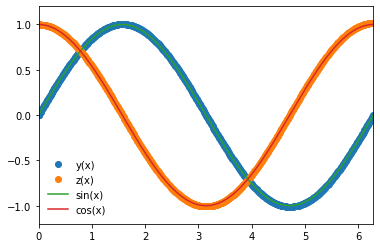

In [12]:
a = 0.0 
b = 2.0*np.pi
y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

x,y = cash_karp_mv(dfdx, a,b,y_0,tolerance, verbose = False)


plt.plot(x,y[:,0], 'o', label ="y(x)")
plt.plot(x,y[:,1], 'o', label ="z(x)")

plt.plot(x, np.sin(x), label ='sin(x)')
plt.plot(x, np.cos(x), label ='cos(x)')

plt.xlim([0,2*np.pi])
plt.ylim([-1.2,1.2])

plt.legend(frameon = False)

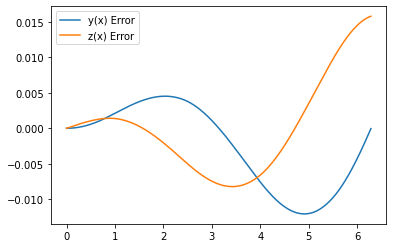

In [14]:
plt.plot(x,y[:,0]-np.sin(x), label = 'y(x) Error')
plt.plot(x,y[:,1]-np.cos(x), label = 'z(x) Error')
plt.legend()